In [1]:
DATA_DIR = "/Users/hasnainmamdani/Academics/McGill/thesis/data/" # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [12]:
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from joblib import load

from random import sample
from nilearn import plotting
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import load_img, resample_to_img
from nilearn.datasets import load_mni152_brain_mask
from IPython.display import display

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

In [3]:
reference_img = load_img("/Users/hasnainmamdani/Academics/McGill/thesis/data/stroke-dataset/HallymBundang_lesionmaps_Bzdok_n1401/1001.nii.gz")
mask_img = load_mni152_brain_mask()
mask_img_resampled = resample_to_img(mask_img, reference_img, interpolation="linear")
masker = NiftiMasker(mask_img=mask_img_resampled, memory='nilearn_cache')
masker = masker.fit()

## Analysis with 100 PC components

In [7]:
pca = load(DATA_DIR + "pca100.joblib")
X_pc = np.load(DATA_DIR + "binary_imgs_pc_100.npy")
X_pc.shape

(1401, 100)

In [4]:
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


In [5]:
# Mixup implementation
def mixup_data(X, Y, alpha=0.1, mul_factor=10):
    
    rs = np.random.RandomState(39)
    n = X.shape[0]
    
    if len(Y.shape)==1:
        Y = Y[:, None]
    
    mixed_X = np.empty((n*(mul_factor-1), X.shape[1]))
    mixed_Y = np.empty((n*(mul_factor-1), Y.shape[1]))

    X1_idx = np.empty((n*(mul_factor-1)), dtype=int)
    X2_idx = np.empty((n*(mul_factor-1)), dtype=int)
    lambdas = np.empty((n*(mul_factor-1)))
    
    for i in range(mul_factor-1):
        
        # sample more than needed as some will be filtered out
        lam = np.random.beta(alpha, alpha, size=round(n*1.2))
        
        # original data vectors will be concatenated later
        lam = lam[(lam!=0.0) & (lam!=1.0)][:n][:, None]
        
        shuffle_idx = rs.choice(np.arange(n), n, replace=False)

        print(mixed_Y.shape, Y.shape)
        print(Y[shuffle_idx].shape, lam.shape)
        aa = lam * Y
        print(aa.shape)
        bb = 1 - lam
        print(bb.shape)
        cc = (1 - lam) * Y[shuffle_idx]
        print(cc.shape)
        
        mixed_X[i*n : (i+1)*n] = lam * X + (1 - lam) * X[shuffle_idx]
        mixed_Y[i*n : (i+1)*n] = lam * Y + (1 - lam) * Y[shuffle_idx]
        
        X1_idx[i*n : (i+1)*n] = np.arange(n)
        X2_idx[i*n : (i+1)*n] = shuffle_idx
        lambdas[i*n : (i+1)*n] = lam.reshape(n)
        
    # concatenate original data vectors
    mixed_X = np.append(mixed_X, X, axis=0)
    mixed_Y = np.append(mixed_Y, Y, axis=0)
    
    X1_idx = np.append(X1_idx, np.arange(n), axis=0)
    X2_idx = np.append(X2_idx, rs.choice(np.arange(n), n, replace=False), axis=0)
    lambdas = np.append(lambdas, np.ones(n), axis=0)
            
    if mixed_Y.shape[1] == 1:
        mixed_Y = np.ravel(mixed_Y)
        
    return mixed_X, mixed_Y, X1_idx, X2_idx, lambdas

In [8]:
mixed_X, mixed_Y, X1_idx, X2_idx, lambdas = mixup_data(X_pc, Y[:,0], alpha=5.0, mul_factor=5)

(5604, 1) (1401, 1)
(1401, 1) (1401, 1)
(1401, 1)
(1401, 1)
(1401, 1)
(5604, 1) (1401, 1)
(1401, 1) (1401, 1)
(1401, 1)
(1401, 1)
(1401, 1)
(5604, 1) (1401, 1)
(1401, 1) (1401, 1)
(1401, 1)
(1401, 1)
(1401, 1)
(5604, 1) (1401, 1)
(1401, 1) (1401, 1)
(1401, 1)
(1401, 1)
(1401, 1)


In [9]:
mixed_Y.shape

(7005,)

In [10]:
np.ravel(mixed_Y).shape

(7005,)

In [11]:
# mixed_X, mixed_Y, X1_idx, X2_idx, lambdas = mixup_data(X_pc, Y, alpha=5.0, mul_factor=5)
print(mixed_X.shape)

(7005, 100)


-------------------------------------------------------------------------------------------------------------



,X₁ scores,X₂ scores,Mixup data scores
Korean MMSE,0.381667,-0.461732,0.106721
Korean Boton Naming,0.294272,0.017577,0.106721
Rey Complex Figure,-1.660653,0.995065,0.106721
Seoul Verbal Learning,-0.979241,0.352071,0.106721
Korean TMT A,-0.294754,0.149346,0.106721
Korean TMT B,-0.754585,0.033634,0.106721


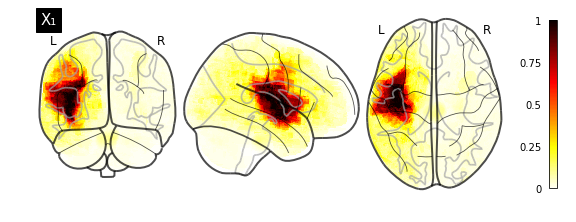

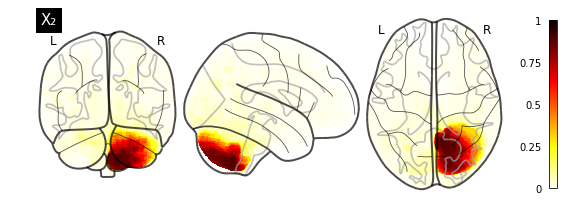

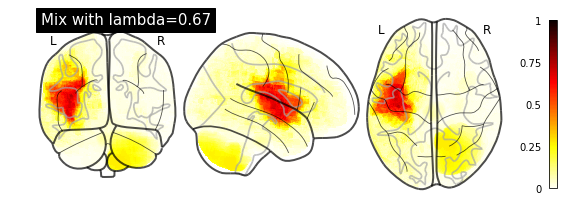

-------------------------------------------------------------------------------------------------------------



,X₁ scores,X₂ scores,Mixup data scores
Korean MMSE,0.381667,0.044307,0.250554
Korean Boton Naming,0.294272,0.294272,0.250554
Rey Complex Figure,-1.660653,-0.056157,0.250554
Seoul Verbal Learning,-0.979241,0.518485,0.250554
Korean TMT A,-0.294754,-0.164137,0.250554
Korean TMT B,-0.754585,-0.582162,0.250554


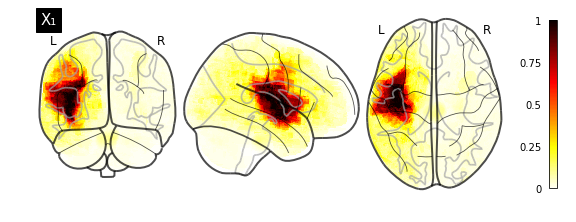

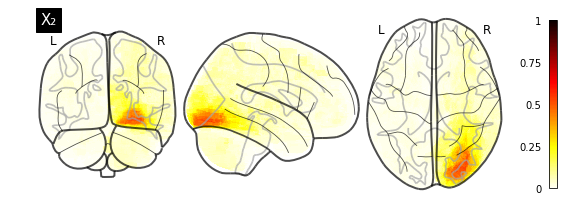

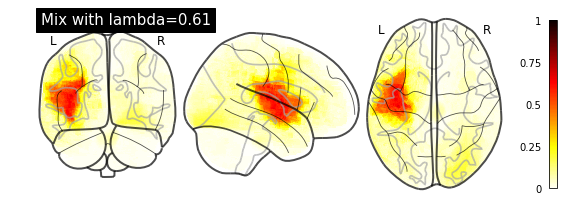

-------------------------------------------------------------------------------------------------------------



,X₁ scores,X₂ scores,Mixup data scores
Korean MMSE,0.381667,-0.293052,-0.169578
Korean Boton Naming,0.294272,-0.812508,-0.169578
Rey Complex Figure,-1.660653,0.441790,-0.169578
Seoul Verbal Learning,-0.979241,-0.812827,-0.169578
Korean TMT A,-0.294754,-0.085766,-0.169578
Korean TMT B,-0.754585,0.772589,-0.169578


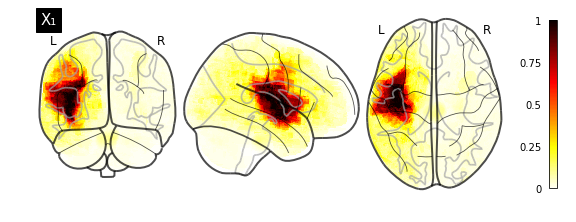

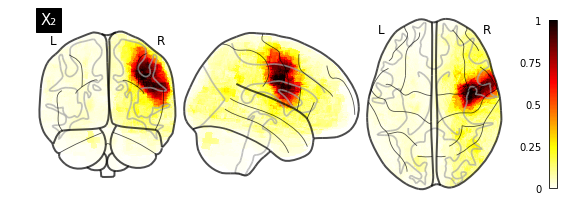

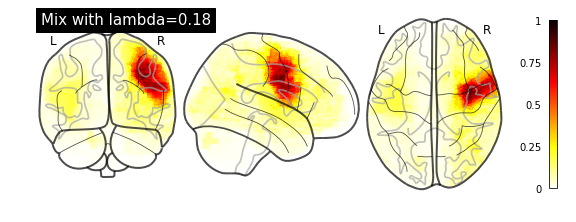

-------------------------------------------------------------------------------------------------------------



,X₁ scores,X₂ scores,Mixup data scores
Korean MMSE,0.381667,-0.799092,0.077721
Korean Boton Naming,0.294272,-0.535813,0.077721
Rey Complex Figure,-1.660653,0.220480,0.077721
Seoul Verbal Learning,-0.979241,-0.812827,0.077721
Korean TMT A,-0.294754,-0.347002,0.077721
Korean TMT B,-0.754585,-2.589658,0.077721


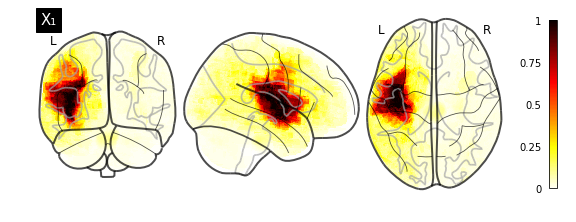

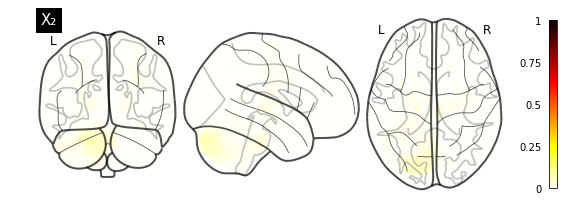

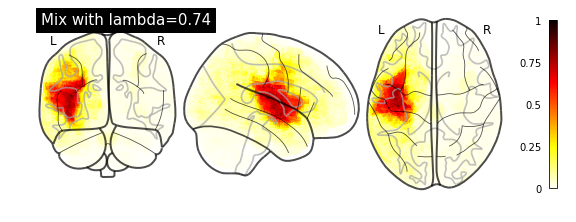

-------------------------------------------------------------------------------------------------------------



,X₁ scores,X₂ scores,Mixup data scores
Korean MMSE,0.381667,0.550346,0.381667
Korean Boton Naming,0.294272,1.401052,0.381667
Rey Complex Figure,-1.660653,0.552445,0.381667
Seoul Verbal Learning,-0.979241,0.518485,0.381667
Korean TMT A,-0.294754,0.567323,0.381667
Korean TMT B,-0.754585,0.600166,0.381667


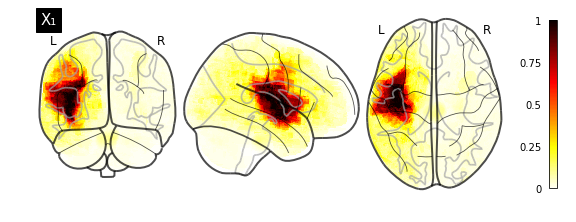

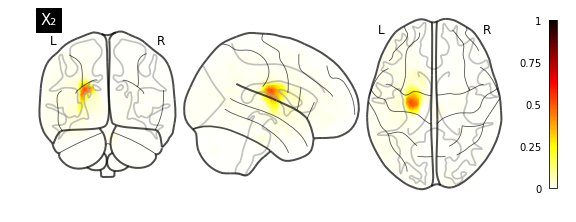

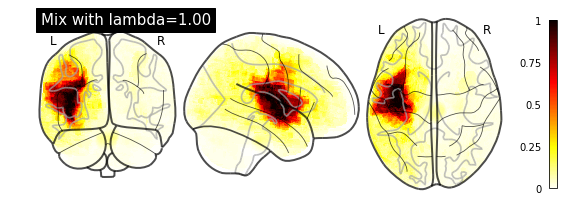

In [14]:
# visualize some samples 

j=0

for p in range(5):
    
    i = 1401*j + 459 # print pairs with sample 459 because #459 is good for visualization.
    
    score_df = pd.DataFrame(index = ["Korean MMSE", "Korean Boton Naming", "Rey Complex Figure", 
                                     "Seoul Verbal Learning", "Korean TMT A", "Korean TMT B"])
    score_df["X\N{SUBSCRIPT ONE} scores"] = Y[X1_idx[i]]
    score_df["X\N{SUBSCRIPT TWO} scores"] = Y[X2_idx[i]]
    score_df["Mixup data scores"] = mixed_Y[i]
    
    print("-------------------------------------------------------------------------------------------------------------\n")
    display(score_df)
#     print("Scores for X\N{SUBSCRIPT ONE}:\t\t", Y[X1_idx[i]])
#     print("Scores for X\N{SUBSCRIPT TWO}:\t\t", Y[X2_idx[i]])
#     print("Lambda:\t\t\t", lambdas[i])
#     print("Scores for mixup-ed data:", mixed_Y[i])
    
    x1_it = masker.inverse_transform(pca.inverse_transform(X_pc[X1_idx[i]]))
    x2_it = masker.inverse_transform(pca.inverse_transform(X_pc[X2_idx[i]]))
    mixed_it = masker.inverse_transform(pca.inverse_transform(mixed_X[i]))
     
    plotting.plot_glass_brain(x1_it, colorbar=True, title="X\N{SUBSCRIPT ONE}", vmin=0, vmax=1)
    plotting.plot_glass_brain(x2_it, colorbar=True, title="X\N{SUBSCRIPT TWO}", vmin=0, vmax=1)
    plotting.plot_glass_brain(mixed_it, colorbar=True, title='Mix with lambda='+"{:.2f}".format(lambdas[i]), vmin=0, vmax=1)
    plt.show()
    j+=1
    

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [-0.46173224  0.01757734  0.99506471  0.35207074  0.1493463   0.03363363]
Lambda:			 0.6659119756435418
Scores for mixup-ed data: [0.09989711]


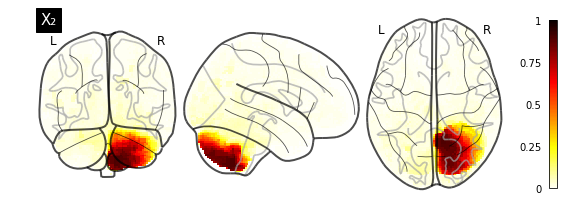

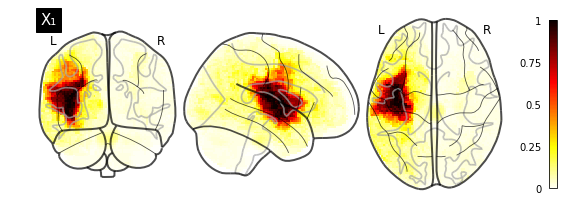

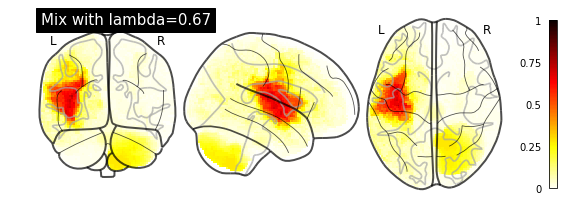

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [ 0.04430703  0.29427232 -0.05615677  0.51848475 -0.1641366  -0.58216245]
Lambda:			 0.6309084037411223
Scores for mixup-ed data: [0.25714998]


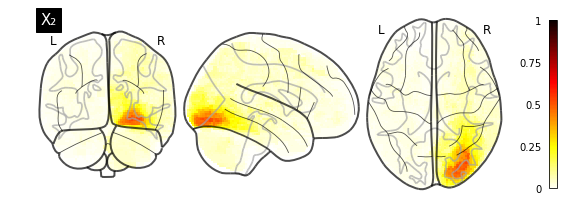

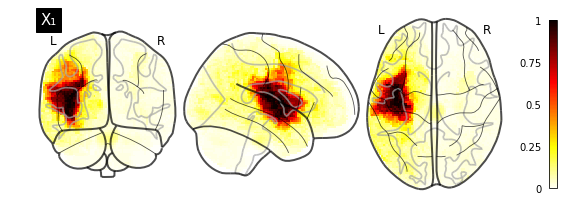

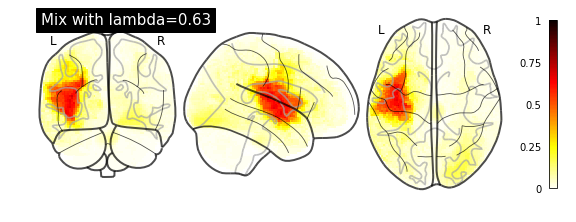

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [-0.29305248 -0.8125076   0.44179025 -0.81282729 -0.08576588  0.77258892]
Lambda:			 0.340712349266573
Scores for mixup-ed data: [-0.06316738]


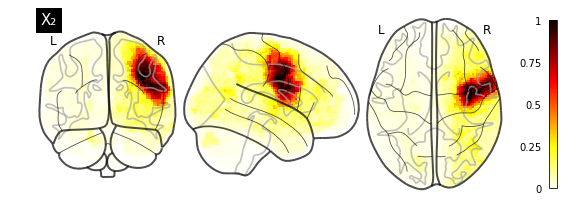

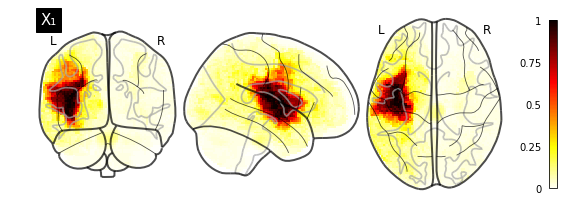

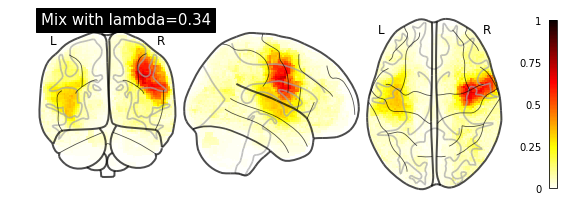

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [-0.79909175 -0.53581262  0.22048046 -0.81282729 -0.34700162 -2.58965765]
Lambda:			 0.2523643983714137
Scores for mixup-ed data: [-0.5011104]


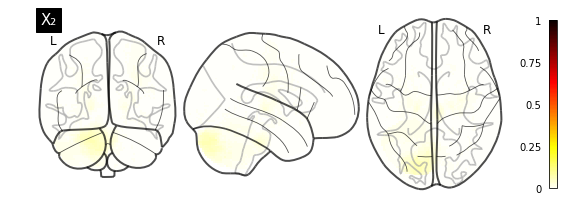

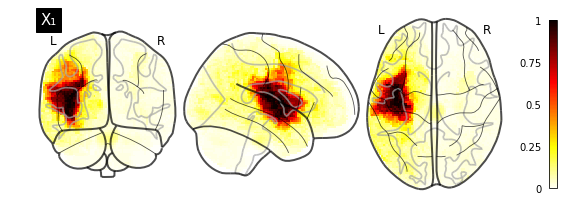

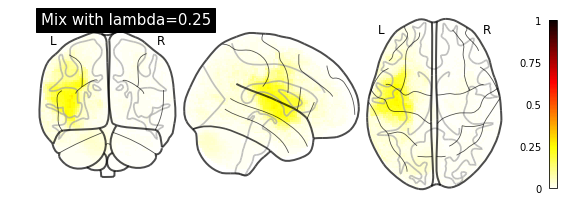

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [0.5503463  1.40105224 0.55244514 0.51848475 0.56732349 0.60016602]
Lambda:			 1.0
Scores for mixup-ed data: [0.38166655]


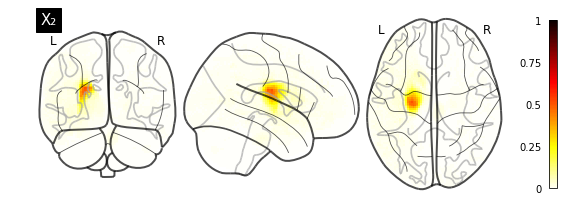

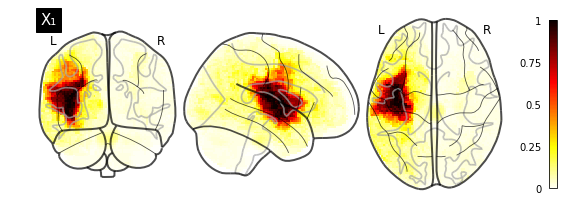

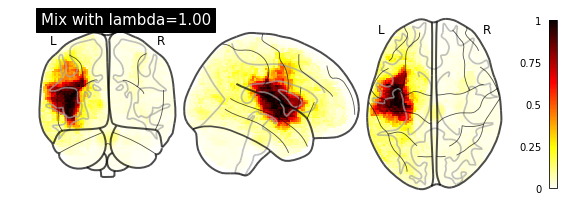

In [28]:
## This is the old stuff using incorrect masker.


j=0

for p in range(5):
    
    i = 1401*j + 459 # print pairs with sample 459 because #459 is good for visualization.
    print("-------------------------------------------------------------------------------------------------------------\n")
    print("Scores for X\N{SUBSCRIPT ONE}:\t\t", Y[X1_idx[i]])
    print("Scores for X\N{SUBSCRIPT TWO}:\t\t", Y[X2_idx[i]])
    print("Lambda:\t\t\t", lambdas[i])
    print("Scores for mixup-ed data:", mixed_Y[i])
    
    x1_it = masker.inverse_transform(pca.inverse_transform(X_pc[X1_idx[i]]))
    x2_it = masker.inverse_transform(pca.inverse_transform(X_pc[X2_idx[i]]))
    mixed_it = masker.inverse_transform(pca.inverse_transform(mixed_X[i]))
     
    plotting.plot_glass_brain(x2_it, colorbar=True, title="X\N{SUBSCRIPT TWO}", vmin=0, vmax=1)
    plotting.plot_glass_brain(x1_it, colorbar=True, title="X\N{SUBSCRIPT ONE}", vmin=0, vmax=1)
    plotting.plot_glass_brain(mixed_it, colorbar=True, title='Mix with lambda='+"{:.2f}".format(lambdas[i]), vmin=0, vmax=1)
    plt.show()
    j+=1
    

In [11]:
5

5